In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature

#from dask.distributed import Client
#client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
#client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Loading in IPO index

CPU times: user 4.53 s, sys: 2.89 s, total: 7.42 s
Wall time: 14.5 s


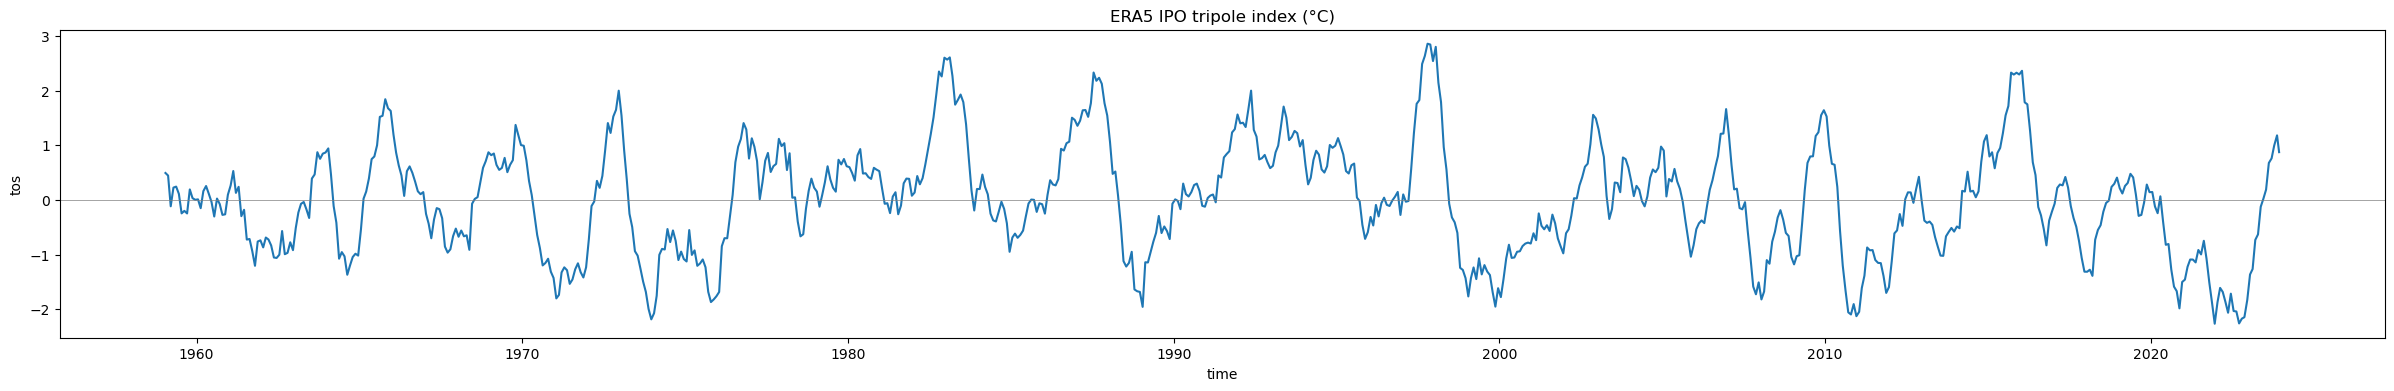

In [2]:
%%time
time_series = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_analysis/'+'JRA55-do_monthly_IPO_tripole_index_1958-2019.nc').tos[12:]
plt.figure(figsize=(30,4)); time_series.plot(); plt.title('ERA5 IPO tripole index (°C)'); plt.axhline(0, lw=.5, c='grey')

### Loading in ERA5 SST and SLP fields

In [3]:
%%time
import glob
var = ['sp', 'sst']
for f in range(2):
    print(var[f])

    base_era = '/g/data/rt52/era5/single-levels/monthly-averaged/'+var[f]+'/'
    filenames = glob.glob(base_era + '*/*.nc')  # list of all .nc files available in the subfolders
    era5_field = xr.open_mfdataset(filenames)[var[f]] # open all the files
    era5_anom = (era5_field.groupby("time.month") - (era5_field[144:493,:,:].groupby("time.month").mean("time"))) # for the climatology, select Jan 1971 to Jan 2000 
    era5_anom.attrs=dict(Note='Anomalies relative to Jan 1971 to Jan 2000 climatology')
    if not os.path.exists('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_'+var[f]+'_monthly_anom_1959-2024.nc'):
        print('file not yet saved, doing that now')
        era5_anom.to_netcdf('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_'+var[f]+'_monthly_anom_1959-2024.nc')
    print('Saving anomalies as .nc file done now')
    print('-------------')
    # Wall time: 1min 38s

sp


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


Saving anomalies as .nc file done now
-------------
sst


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


Saving anomalies as .nc file done now
-------------
CPU times: user 21.9 s, sys: 6.94 s, total: 28.9 s
Wall time: 2min 1s


Text(0.5, 1.0, 'sst anomaly map (°C)')

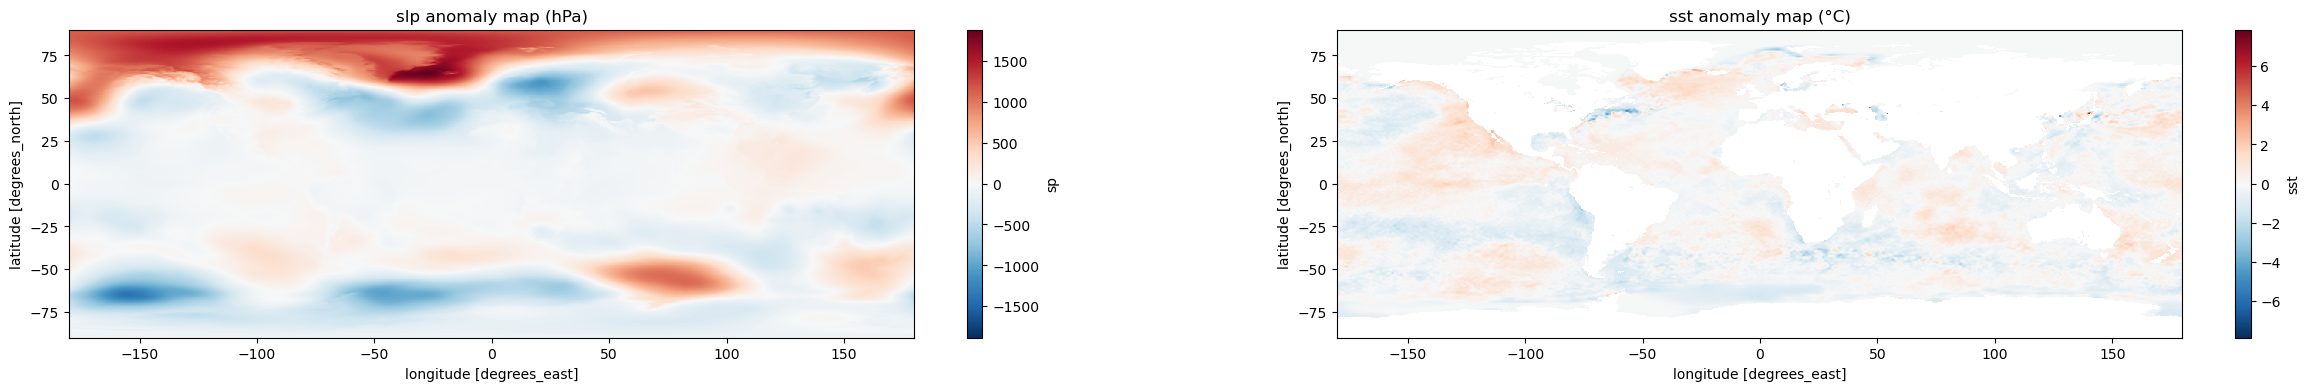

In [4]:
slp_field = xr.open_mfdataset('/g/data/e14/mv7494/ERA5/monthly_anom/' + 'ERA5_sp_monthly_anom_1959-2024.nc').sp[:-5,:,:]
tos_field = xr.open_mfdataset('/g/data/e14/mv7494/ERA5/monthly_anom/' + 'ERA5_sst_monthly_anom_1959-2024.nc').sst[:-5,:,:]
plt.figure(figsize=(30,4))
plt.subplot(1,2,1); slp_field[0,:,:].plot(); plt.title('slp anomaly map (hPa)')
plt.subplot(1,2,2); tos_field[0,:,:].plot(); plt.title('sst anomaly map (°C)')

CPU times: user 12.6 s, sys: 22.1 s, total: 34.6 s
Wall time: 59.6 s


Text(0.5, 1.0, 'sst regression map (°C)')

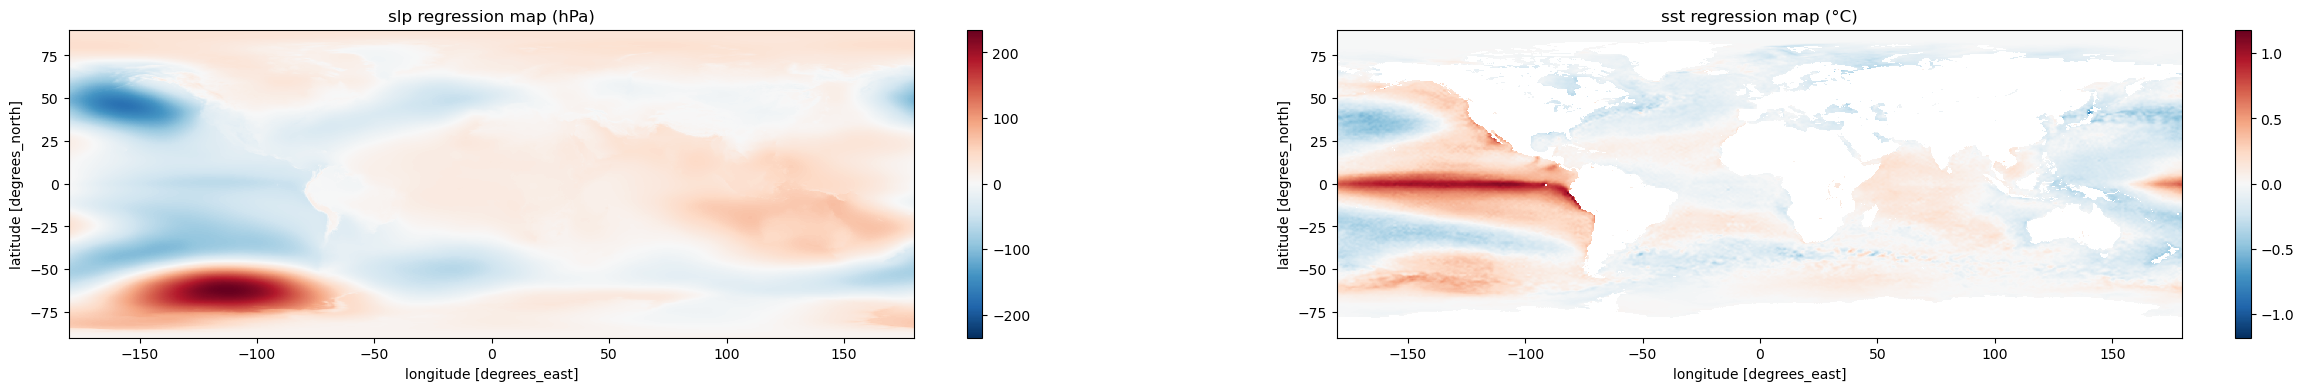

In [5]:
%%time
for v in range(2):
    if v == 0: field = slp_field
    if v == 1: field = tos_field
        
    field['time'] = time_series.time
    regression_map = ((field*time_series) / np.std(time_series)).mean('time').load()
    if v == 0: slp_regression_map = regression_map
    if v == 1: sst_regression_map = regression_map

plt.figure(figsize=(30,4))
plt.subplot(1,2,1); slp_regression_map.plot(); plt.title('slp regression map (hPa)')
plt.subplot(1,2,2); sst_regression_map.plot(); plt.title('sst regression map (°C)')
# Wall time: 28.5 s

### Plotting routine for NSF proposal figure

CPU times: user 20 s, sys: 206 ms, total: 20.2 s
Wall time: 20.3 s


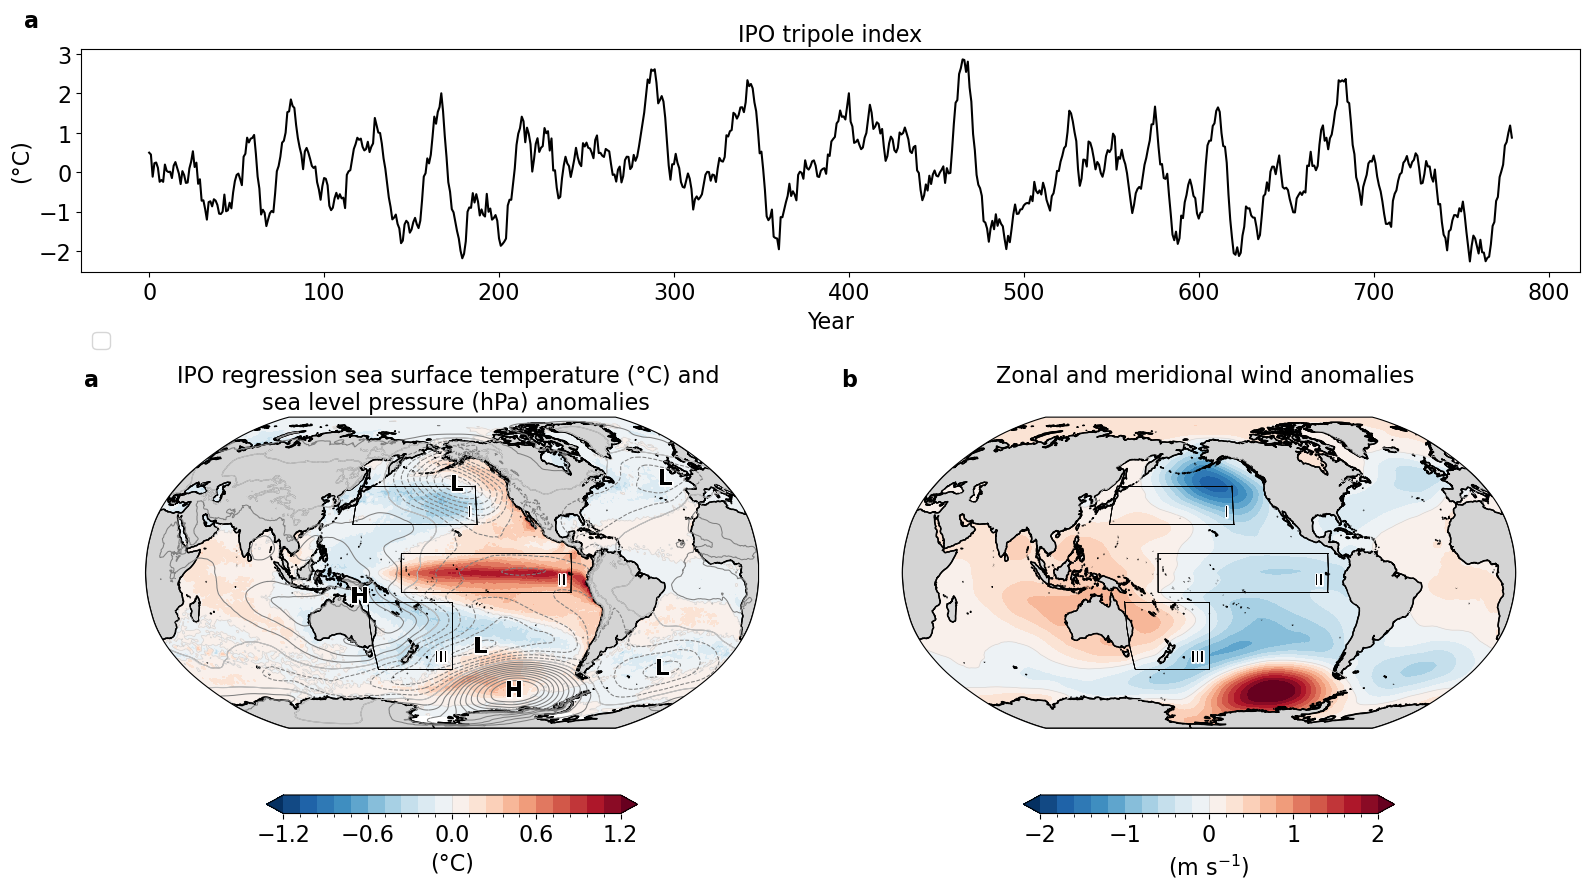

In [7]:
%%time
import matplotlib.patheffects as PathEffects
from wrf import to_np # conversion to arrays required for arrows on maps    

fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k'); 
gs = gridspec.GridSpec(2,2, height_ratios=[.5,1]) 
ax1 = plt.subplot(gs[0,:]) # long first panel

# -------------------------------------------------------------------------------------------- #
plt.plot(time_series, c='k', linewidth=1.5) # plot the data
# -------------------------------------------------------------------------------------------- #

plt.title('IPO tripole index', fontsize=16)

plt.legend(ncol=2,fontsize=16, bbox_to_anchor=(0, -.4), loc='lower left') # figure legend outside
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

ax1.text(-.038, 1.1,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# second and third panels with SST, SLP, and winds ---------------------------------------------- #
for f in range(2):
    if f == 0: 
        panel = gs[1,0]; 
        data1 = sst_regression_map; ticks1 = np.linspace(-1.2,1.2,21)
        data2 = slp_regression_map / 100; ticks2 = np.linspace(-2,2,21)
        title_str = 'IPO regression sea surface temperature (°C) and \n sea level pressure (hPa) anomalies'
    if f == 1: 
        panel = gs[1,1] 
        data1 = slp_regression_map / 100; ticks1 = np.linspace(-2,2,21)
        data2 = sst_regression_map
        title_str = 'Zonal and meridional wind anomalies \n'
    
    
    
    ax1 = plt.subplot(panel, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    def fancy_plot(axes_nr):
        axes_nr.coastlines(resolution = '50m', linewidth=1) # add coast lines
        axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
        axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    # ---------------------------------------------------------------------------------------------------------------------------------------------------- #
    p1  = data1.plot.contourf(ax=ax1, levels = ticks1, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = data1.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())
    
    if f == 0:
        p2  = data2.plot.contour(ax=ax1, levels = ticks2, colors='grey',linewidths=.75, transform=ccrs.PlateCarree())
        p22 = data2.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree())  

        # hard-coding the labels here. Not pretty but works and likely faster than doing it in an efficient way :-)
        # use the following line to find longitude and latitude of min/max within a region
        # peak_anom_coords = slp_map.where(slp_map == slp_map.min(), drop=True).longitude # this is how I get the coordinates of the maximum anomaly amplitude

        peak_anom_coords = [-113.5, -62.25, -157., 45.75, -17, 49, 145.25, -12.25, -142.25, -38.25, -18, -50] 
        for l,m in zip(peak_anom_coords[0::2],peak_anom_coords[1::2]):
            if l in [-157, -17, -142.25, -18]: symbol = 'L'
            else: symbol = 'H'

            txt = txt = plt.text(l, m, symbol, c='k', fontsize=16, fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    for r in range(3): # loop through the three regions
        if r == 0: TPI_bnds = [140, 215,  25,  45]; region = 'I'
        if r == 1: TPI_bnds = [170, 270, -10,  10]; region = 'II'
        if r == 2: TPI_bnds = [150, 200, -50, -15]; region = 'III'
        for d in range(4):
            txt = plt.plot([TPI_bnds[0],TPI_bnds[0]], [TPI_bnds[2], TPI_bnds[3]], color = 'k', linewidth=.5, transform=ccrs.PlateCarree(),) # left line
            txt = plt.plot([TPI_bnds[1],TPI_bnds[1]], [TPI_bnds[2], TPI_bnds[3]], color = 'k', linewidth=.5, transform=ccrs.PlateCarree(),) # right line
            txt = plt.plot([TPI_bnds[0],TPI_bnds[1]], [TPI_bnds[2], TPI_bnds[2]], color = 'k', linewidth=.5, transform=ccrs.PlateCarree(),) # bottom line
            txt = plt.plot([TPI_bnds[0],TPI_bnds[1]], [TPI_bnds[3], TPI_bnds[3]], color = 'k', linewidth=.5, transform=ccrs.PlateCarree(),) # top line
        txt = plt.text(TPI_bnds[1]-3,TPI_bnds[2]+6, region, va='center',transform=ccrs.PlateCarree(), fontsize = 11, ha='right') # include N34 value in plot
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.5, orientation='horizontal'); 
    if f == 0: cb.set_label(label='(°C)', size=16)
    if f == 1: cb.set_label(label='(m s$^{-1}$)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar
    fancy_plot(ax1)

    plt.title(title_str, size=16)
    

    ax1.text(-.1, 1.1,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# --- saving as 300 dpi .PNG image in specified folder --------------------------------------- #
plt.savefig(save + 'IPO_regression_map_SST_and_SLP', dpi=300, facecolor='w',           #
            edgecolor='w', orientation='landscape',
            format=None, transparent=False, bbox_inches='tight',                               #
            pad_inches=0.1, metadata=None)                                                     #
# --- end of script -------------------------------------------------------------------------- #
# Wall time: 21.8 s